This notebook focuses on sources that provide predictions over a period of time. We want to examine how the performance of these models changes as we get closer to the election. 

Note that only FiveThirtyEight provided their state-level predictions for the election over time (for most models, we could only find the state-level predictions released on the day of the election.)  

The Economist, FiveThirtyEight, PollyVote, and PredictIt provided predictions over time for the national electoral outcome.

In [60]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sb

%matplotlib inline

## State-level (FiveThirtyEight only) 

Some of these methods are adapted from code in Buzzfeed's 2016 election forecasts [repository](https://github.com/BuzzFeedNews/2016-11-grading-the-election-forecasts/blob/master/notebooks/forecast-analysis.ipynb). 

In [3]:
DATA_DIR = "./597E-assignment1/data"
WINNERS_PATH = os.path.join(DATA_DIR, 'winners.csv')

winners = pd.read_csv(WINNERS_PATH)

In [4]:
winners.head()

,office,state,winner,dem_diff,dem_share,dem_share_2p,candidates
0,P,AZ,Biden,0.003,0.494,0.501523,BIDEN|TRUMP
1,P,FL,Trump,-0.034,0.479,0.483350,BIDEN|TRUMP
2,P,GA,Biden,0.003,0.495,0.501012,BIDEN|TRUMP
3,P,IA,Trump,-0.082,0.449,0.458163,BIDEN|TRUMP
4,P,ME2,Trump,-0.079,0.447,0.458932,BIDEN|TRUMP


In [2]:
# Counting only Maine and Nebraska's statewide electoral votes
ELECTORAL_VOTES = pd.Series({
    "AL": 9, "AK": 3, "AZ": 11, "AR": 6, "CA": 55, "CO": 9, "CT": 7,
    "DE": 3, "DC": 3, "FL": 29, "GA": 16, "HI": 4, "ID": 4, "IL": 20, "IN": 11,
    "IA": 6, "KS": 6, "KY": 8, "LA": 8, "ME": 2, "MD": 10, "MA": 11, "MI": 16,
    "MN": 10, "MS": 6, "MO": 10, "MT": 3, "NE": 2, "NV": 6, "NH": 4, "NJ": 14,
    "NM": 5, "NY": 29, "NC": 15, "ND": 3, "OH": 18, "OK": 7, "OR": 7, "PA": 20,
    "RI": 4, "SC": 9, "SD": 3, "TN": 11, "TX": 38, "UT": 6, "VT": 3,
    "VA": 13, "WA": 12, "WV": 5, "WI": 10, "WY": 3
})

def get_evs(abbr):
    return ELECTORAL_VOTES.get(abbr)

In [5]:
evs_called = pd.Series(winners[
    (winners["office"] == "P") &
    (winners["winner"].notnull())
]["state"].unique()).apply(get_evs).sum()

In [6]:
def get_credits(race):
    max_prob = race["win_prob"].max()
    at_max = race["win_prob"] == max_prob
    favorites = race[at_max]
    credit = (1 / len(favorites)) * favorites["correct"]
    return credit.sum()

In [7]:
def brier_score_race_statelevel(called_forecast):
    uniques = called_forecast[[
        "date", "office", "state", "model"
    ]].apply(lambda x: x.nunique())
    assert((uniques != 1).sum() == 0)
    errors = called_forecast["win_prob"] - called_forecast["correct"]
    errors_squared = (errors).pow(2).sum()
    # If you didn't put odds on the candidate, add 1
    if called_forecast["correct"].sum() == 0:
        errors_squared += 1
    return errors_squared / 2  # divide by 2 bc there are 2 forecasts: Biden and Trump

In [11]:
def forecast_scores_statelevel(forecasts):
    called = pd.merge(winners, forecasts, on=['office', 'state'], how='left').dropna(
        subset=['winner'])
    called['correct'] = called['winner'] == called['candidate']
    
    scores = pd.merge(
        called, forecasts[['date', 'model']].drop_duplicates(),
        how='inner', on=['date', 'model']
    ).groupby([
        'date', 'office', 'state', 'model']).apply(brier_score_race_statelevel)\
            .reset_index()\
            .rename(columns={0: 'brier_score'})
    scores.loc[((scores['office'] == 'P')), 'brier_evs'] = scores.apply(
        lambda x: x['brier_score'] * get_evs(x['state']), axis=1)
    credits = pd.DataFrame({
        "credit": called.groupby([
                "date", "model", "office", "state"
            ]).apply(get_credits)
    }).reset_index()
    scores = pd.DataFrame({
        "pres_brier_flat": scores.groupby("model")["brier_score"].mean(),
        "pres_brier_evs": scores.groupby("model")["brier_evs"].sum() / evs_called,
        "pres_correct": credits[credits["office"] == "P"].groupby("model")["credit"].sum(),
    })
    return scores
    

In [9]:
fivethirtyeight_sl = pd.read_csv(os.path.join(DATA_DIR, 'state-level', 'fivethirtyeight.csv'))
fivethirtyeight_sl.head()

,date,model,office,state,party,candidate,win_prob,est_diff,est_share,est_share_2p
0,2020-11-03,fivethirtyeight-polls-plus,P,WY,D,Biden,0.001625,-0.347310,NaN,0.320649
1,2020-11-03,fivethirtyeight-polls-plus,P,WY,R,Trump,0.998375,0.347310,NaN,0.679351
2,2020-11-03,fivethirtyeight-polls-plus,P,WI,D,Biden,0.943575,0.083110,NaN,0.541946
3,2020-11-03,fivethirtyeight-polls-plus,P,WI,R,Trump,0.056425,-0.083110,NaN,0.458054
4,2020-11-03,fivethirtyeight-polls-plus,P,WV,D,Biden,0.007175,-0.307147,NaN,0.343702


In [12]:
fivethirtyeight_sl_history = fivethirtyeight_sl[fivethirtyeight_sl["date"] >= "2020-06-01"].groupby("date")\
    .apply(lambda x: forecast_scores_statelevel(x))

In [13]:
fivethirtyeight_sl_history

,,pres_brier_flat,pres_brier_evs,pres_correct
date,model,,,
2020-06-01,fivethirtyeight-polls-plus,0.043574,0.067323,48.0
2020-06-02,fivethirtyeight-polls-plus,0.043695,0.067640,48.0
2020-06-03,fivethirtyeight-polls-plus,0.043429,0.067301,48.0
2020-06-04,fivethirtyeight-polls-plus,0.043279,0.067018,48.0
2020-06-05,fivethirtyeight-polls-plus,0.043627,0.065896,48.0
...,...,...,...,...
2020-10-30,fivethirtyeight-polls-plus,0.035627,0.062752,49.0
2020-10-31,fivethirtyeight-polls-plus,0.034846,0.063489,49.0
2020-11-01,fivethirtyeight-polls-plus,0.035638,0.065582,49.0


In [14]:
COLORS = [ 
    "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", 
    "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a", "#ffff99", "#b15928"
] # via ColorBrewer2.org

def plot_history_statelevel(history, var, title=""):
    chart_min = history[var].max()*1.1
    chart_max = history[var].min()/1.1
    vals = history[var].unstack()#.rename(columns=TRANSLATIONS)
    vals.index = pd.to_datetime(vals.index)
    ax = vals.plot(
        ylim=(chart_min, chart_max),
        color=COLORS,
        marker="o",
        markersize=5,
        alpha=0.75,
        figsize=(10, 6),
    )
    #ax.set_axis_bgcolor('black')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True, color="white", alpha=0.5)
    #sb.plt.vlines(["2016-11-07"], ymin=chart_min, ymax=chart_max, lw=1, alpha=0.9, color="white")
    ax.set_xlim((ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1))
    ax.set_xlabel("")
    #for text in ax.legend(loc="lower left").get_texts():
    #    text.set_color("white")
    #    text.set_weight("bold")
    ax.set_title(title, fontsize=18)

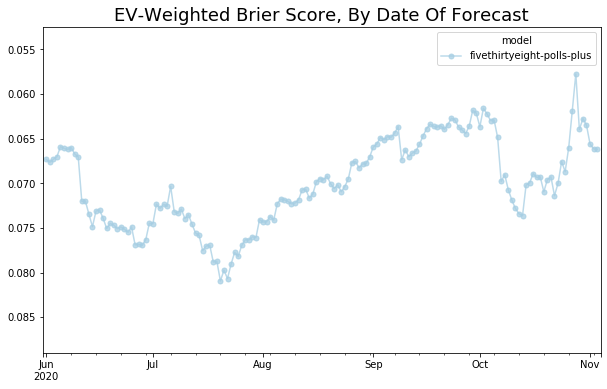

In [15]:
plot_history_statelevel(fivethirtyeight_sl_history,
                        "pres_brier_evs", "EV-Weighted Brier Score, By Date Of Forecast")

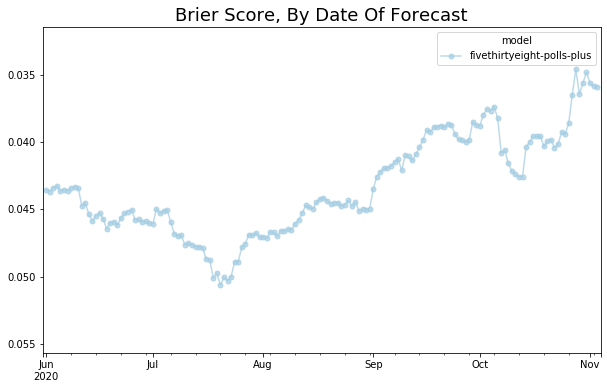

In [17]:
plot_history_statelevel(fivethirtyeight_sl_history,
             "pres_brier_flat", "Brier Score, By Date Of Forecast")

## national-level

Hard-coded proportion of votes for the different parties, pulled from the [Cook political report](https://cookpolitical.com/2020-national-popular-vote-tracker)

In [22]:
DEM_VOTE_P = .51
REP_VOTE_P = .472
OTHER_VOTE_P = .018

DEM_MARGIN = .039

In [23]:
DEM_VOTE_2P = DEM_VOTE_P / (DEM_VOTE_P + REP_VOTE_P)
REP_VOTE_2P = REP_VOTE_P / (DEM_VOTE_P + REP_VOTE_P)

In [63]:
def brier_score_nat_outcome(called_forecast):
    if called_forecast['win_prob'].isnull().values.any():
        return np.nan
    uniques = called_forecast[[
        "date", "office", "model"
    ]].apply(lambda x: x.nunique())
    assert((uniques != 1).sum() == 0)
    errors = called_forecast["win_prob"] - called_forecast["win_correct"]
    errors_squared = (errors).pow(2).sum()
    # If you didn't put odds on the candidate, add 1
    if called_forecast["win_correct"].sum() == 0:
        errors_squared += 1
    return errors_squared / 2  # 2 forecasts - Biden and Trump

In [57]:
def brier_score_nat_voteshare(called_forecast):
    if called_forecast['est_share_2p'].isnull().values.any():
        return np.nan
    uniques = called_forecast[[
        "date", "office", "model"
    ]].apply(lambda x: x.nunique())
    assert((uniques != 1).sum() == 0)
    errors = called_forecast["est_share_2p"] - called_forecast["vote_2p_correct"]
    errors_squared = (errors).pow(2).sum()
    # If you didn't put odds on the candidate, add 1
    if called_forecast["vote_2p_correct"].sum() == 0:
        errors_squared += 1
    return errors_squared / 2  # 2 forecasts - Biden and Trump

In [86]:
def forecast_scores_nat(forecasts):
    forecasts['win_correct'] = 'Biden' == forecasts['candidate']
    forecasts['vote_2p_correct'] = [
        DEM_VOTE_2P if p == 'Biden' else REP_VOTE_2P for p in forecasts['candidate']]
    win_scores = forecasts.groupby([
        'date', 'office', 'model']).apply(brier_score_nat_outcome)\
        .reset_index()\
        .rename(columns={0: 'pres_win_brier'})
    voteshare_scores = forecasts.groupby([
        'date', 'office', 'model']).apply(brier_score_nat_voteshare)\
        .reset_index()\
        .rename(columns={0: 'pres_voteshare_brier'})
    scores = pd.merge(
        win_scores, voteshare_scores, on=['date', 'office', 'model'])
    #scores.set_index(['date'], inplace=True)
    
    return scores
    

In [21]:
source_dfs = []
for fn in os.listdir(os.path.join(DATA_DIR, 'national-level')):
    print(fn)
    df = pd.read_csv(os.path.join(DATA_DIR, 'national-level', fn))
    source_dfs.append(df)
national_forecasts = pd.concat(source_dfs, axis=0)
national_forecasts.shape

pollyvote.csv
fivethirtyeight.csv
predictit.csv
economist.csv


(1076, 9)

In [87]:
model_histories_nl = national_forecasts.groupby("model")\
    .apply(lambda x: forecast_scores_nat(x))

In [88]:
model_histories_nl.head()

date office      model  pres_win_brier  \
model                                                       
PredictIt 0  2020-08-24      P  PredictIt        0.178994   
          1  2020-08-25      P  PredictIt        0.187223   
          2  2020-08-26      P  PredictIt        0.199453   
          3  2020-08-27      P  PredictIt        0.199453   
          4  2020-08-28      P  PredictIt        0.208219   

             pres_voteshare_brier  
model                              
PredictIt 0                   NaN  
          1                   NaN  
          2                   NaN  
          3                   NaN  
          4                   NaN

In [90]:
model_histories_nl = model_histories_nl.set_index(['date', 'model'])

In [96]:
COLORS = [ 
    "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", 
    "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a", "#ffff99", "#b15928"
] # via ColorBrewer2.org

def plot_history_nationallevel(history, var, title=""):
    chart_min = history[var].max()*1.1
    chart_max = history[var].min()/1.1
    vals = history[var].unstack()#.rename(columns=TRANSLATIONS)
    vals.index = pd.to_datetime(vals.index)
    ax = vals.plot(
        ylim=(chart_min, chart_max),
        color=COLORS,
        marker="o",
        markersize=5,
        alpha=0.75,
        figsize=(18, 6),
    )
    #ax.set_axis_bgcolor('black')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True, color="white", alpha=0.5)
    #sb.plt.vlines(["2016-11-07"], ymin=chart_min, ymax=chart_max, lw=1, alpha=0.9, color="white")
    ax.set_xlim((ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1))
    ax.set_xlabel("")
    #for text in ax.legend(loc="lower left").get_texts():
    #    text.set_color("white")
    #    text.set_weight("bold")
    ax.set_title(title, fontsize=18)

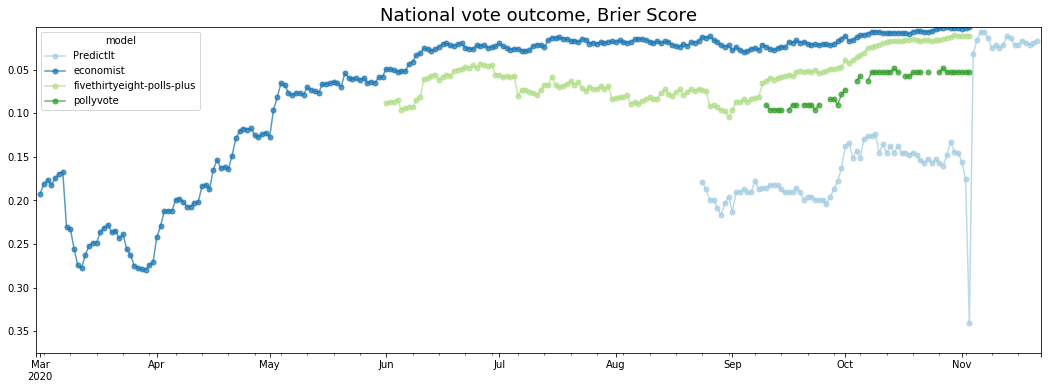

In [97]:
plot_history_nationallevel(model_histories_nl, 'pres_win_brier', title='National vote outcome, Brier Score')